## Install Dependencies and Setup

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
from google.colab import files

Defining global variables

In [2]:
BATCH_SIZE   = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH  = 224
OUTPUT_SHAPE = 53
IN_CHANNELS  = 3
EPOCHS       = 25

# import subprocess
# OUTPUT_SHAPE = int(subprocess.run("find /content/cards-image-datasetclassification/train -mindepth 1 -maxdepth 1 -type d | wc -l",
#                               shell=True, capture_output=True, text=True).stdout.strip())

# OUTPUT_SHAPE = len(train_dataset.classes) safer and simpler

Defining global functions

## Load Data

In [4]:
from google.colab import files
import os

# Use Python to check if any files exist
if not any(os.path.isfile(f) for f in os.listdir('.')):
    print("No files found in the current folder.")

    # Upload kaggle.json
    files.upload()

    # Use shell-style commands
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    !kaggle datasets download -d gpiosenka/cards-image-datasetclassification > /dev/null 2>&1
    !unzip -o cards-image-datasetclassification.zip -d cards-image-datasetclassification > /dev/null 2>&1

else:
    print("Files already loaded.")

No files found in the current folder.


Saving kaggle.json to kaggle.json


In [5]:
transform = ToTensor() # simple transformer, no need to preprocess images

In [6]:
dir = "/content/cards-image-datasetclassification"

# Load datasets with the same transform
# Structure: list(tuple(torch.Tensor, int))
#   [(torch.Tensor, class)]
#   torch.Tensor: [channels, height, width] -> [3, 224, 224]
#   class: int

train_dataset = datasets.ImageFolder(root=f"{dir}/train", transform=transform)
valid_dataset = datasets.ImageFolder(root=f"{dir}/valid", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dir}/test", transform=transform)

# print(train_dataset[0][0].shape)

In [7]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Shape: [[torch.Tensor], [class]]
# (32, 3, 244, 244) 4D vector

## Preprocess Data

Data is already well-formed: all images are 224x224 pixels. Idea: we can remove Blue and Green channels and work only with Red.

## Build Deep Learning Model

In [8]:
class CardClassifier(nn.Module):
    def __init__(self, in_channels=3, output_shape=10):
        super().__init__()

        self.convolutional_layers = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # Output shape = (32, 256, 1, 1)
        )

        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, output_shape)
        )

    def forward(self, x):
        x = self.convolutional_layers(x)
        x = self.linear_layers(x)
        return x

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CardClassifier(in_channels=IN_CHANNELS, output_shape=OUTPUT_SHAPE).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

## Utility Functions

In [10]:
def calculate_accuracy(y_pred, y_true):
    predicted = torch.argmax(y_pred, dim=1)
    correct = (predicted == y_true).sum().item()
    return correct / len(y_true)

# Train phase
def train_one_epoch(model, loader, optimizer, loss_fn, device):
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for images, labels in tqdm(loader, desc="Training", leave=False):
    images, labels = images.to(device), labels.to(device)          # should be on the same device -
                                                                   # required by PyTorch

    optimizer.zero_grad()                                          # clears out the gradients from the
                                                                   # previous iteration
    outputs = model(images)                                        # forward pass
                                                                   # shape: [batch_size, num_classes]
    loss = loss_fn(outputs, labels)                                # loss calculation
    loss.backward()                                                # backpropagation - compute gradients
    optimizer.step()                                               # updates the weights in the direction
                                                                   # that reduces the loss.
                                                                   # move each weight towards local minimum
    # new_weight = current_weight - learning_rate * gradient -> evaluated at current weight
    #                                               gradient = ∇L(w)
    # The gradient of the loss function L with respect to weights w, evaluated at the current value of w.

    running_loss += loss.item()                                    # converts tensor loss to float
                                                                   # summing the loss for all batches per epoch
    correct += (outputs.argmax(1) == labels).sum().item()          # argmax across 1st dim
    total += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
  return avg_loss, accuracy


# Validation (inference) phase
def validate_one_epoch(model, loader, loss_fn, device):
  model.eval()
  running_loss = 0.0
  correct = 0
  total = 0

  with torch.no_grad():   # gradients are needed only during training.
                          # Temporary turning the off using 'with'

    for images, labels in tqdm(loader, desc="Validating", leave=False):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = loss_fn(outputs, labels)

      running_loss += loss.item()
      correct += (outputs.argmax(1) == labels).sum().item()
      total += labels.size(0)

    avg_loss = running_loss / len(loader)
    accuracy = correct / total
  return avg_loss, accuracy

## Train And Validate Model

In [11]:
from tqdm.auto import tqdm

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in tqdm(range(EPOCHS), desc="Epochs"):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = validate_one_epoch(model, valid_loader, loss_fn, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch + 1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc * 100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc * 100:.2f}%\n")


Epochs:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [1/25]
Train Loss: 3.4999 | Train Acc: 6.98%
Val Loss: 3.2257 | Val Acc: 7.92%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [2/25]
Train Loss: 3.1284 | Train Acc: 11.40%
Val Loss: 3.0141 | Val Acc: 9.06%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [3/25]
Train Loss: 2.9807 | Train Acc: 13.56%
Val Loss: 2.7470 | Val Acc: 15.09%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [4/25]
Train Loss: 2.8237 | Train Acc: 16.99%
Val Loss: 2.5600 | Val Acc: 23.40%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [5/25]
Train Loss: 2.6889 | Train Acc: 19.94%
Val Loss: 2.5590 | Val Acc: 20.38%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [6/25]
Train Loss: 2.5602 | Train Acc: 23.89%
Val Loss: 2.2407 | Val Acc: 28.68%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [7/25]
Train Loss: 2.4544 | Train Acc: 25.29%
Val Loss: 2.2583 | Val Acc: 24.15%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [8/25]
Train Loss: 2.3712 | Train Acc: 27.07%
Val Loss: 2.0214 | Val Acc: 30.57%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [9/25]
Train Loss: 2.3107 | Train Acc: 28.32%
Val Loss: 2.1287 | Val Acc: 26.79%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [10/25]
Train Loss: 2.2431 | Train Acc: 30.65%
Val Loss: 2.0235 | Val Acc: 32.08%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [11/25]
Train Loss: 2.1523 | Train Acc: 33.17%
Val Loss: 2.1004 | Val Acc: 32.08%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [12/25]
Train Loss: 2.0857 | Train Acc: 34.99%
Val Loss: 1.8342 | Val Acc: 42.26%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [13/25]
Train Loss: 2.0170 | Train Acc: 38.46%
Val Loss: 1.6850 | Val Acc: 46.42%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [14/25]
Train Loss: 1.9388 | Train Acc: 41.17%
Val Loss: 1.6516 | Val Acc: 45.66%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [15/25]
Train Loss: 1.8774 | Train Acc: 44.22%
Val Loss: 1.7555 | Val Acc: 43.77%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [16/25]
Train Loss: 1.7880 | Train Acc: 46.21%
Val Loss: 1.3929 | Val Acc: 56.98%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [17/25]
Train Loss: 1.7094 | Train Acc: 49.71%
Val Loss: 1.5510 | Val Acc: 49.81%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [18/25]
Train Loss: 1.6227 | Train Acc: 51.68%
Val Loss: 1.5473 | Val Acc: 50.19%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [19/25]
Train Loss: 1.5685 | Train Acc: 53.38%
Val Loss: 1.2435 | Val Acc: 66.04%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [20/25]
Train Loss: 1.4789 | Train Acc: 56.16%
Val Loss: 1.2487 | Val Acc: 68.68%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [21/25]
Train Loss: 1.4200 | Train Acc: 57.73%
Val Loss: 1.1951 | Val Acc: 65.66%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [22/25]
Train Loss: 1.3556 | Train Acc: 59.51%
Val Loss: 1.1045 | Val Acc: 70.94%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [23/25]
Train Loss: 1.2986 | Train Acc: 61.50%
Val Loss: 0.9599 | Val Acc: 76.23%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [24/25]
Train Loss: 1.2474 | Train Acc: 63.51%
Val Loss: 1.0881 | Val Acc: 69.81%



Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validating:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch [25/25]
Train Loss: 1.1807 | Train Acc: 65.92%
Val Loss: 0.9662 | Val Acc: 73.21%



## Measure Performance

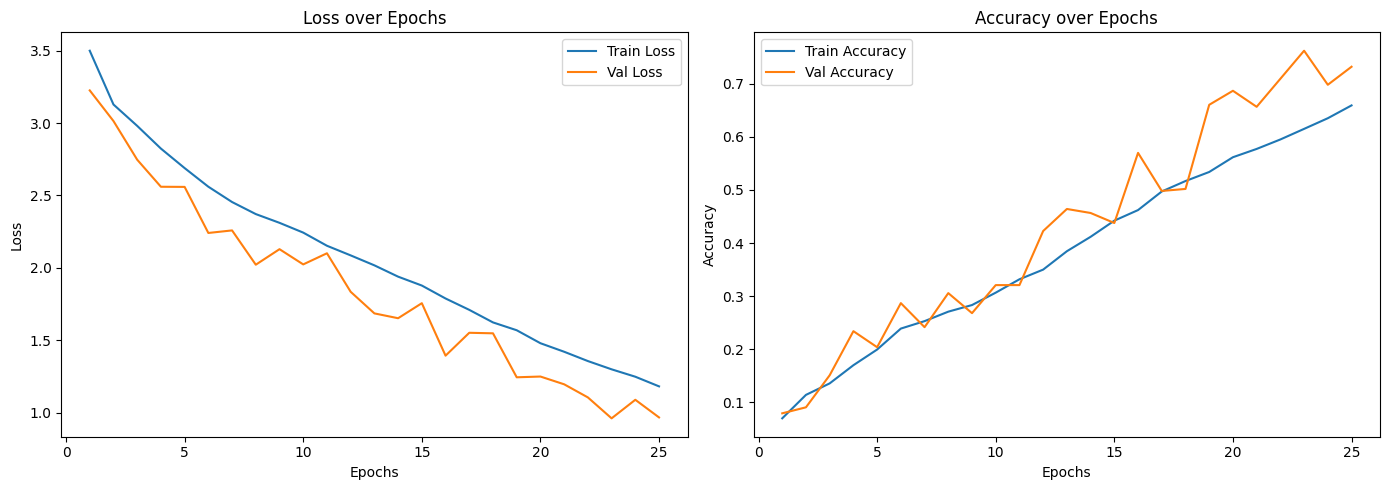

In [13]:
from matplotlib import pyplot as plt
# Plotting results
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
! pip show torchmetrics > /dev/null 2>&1 && echo "installed" || pip install torchmetrics > /dev/null 2>&1

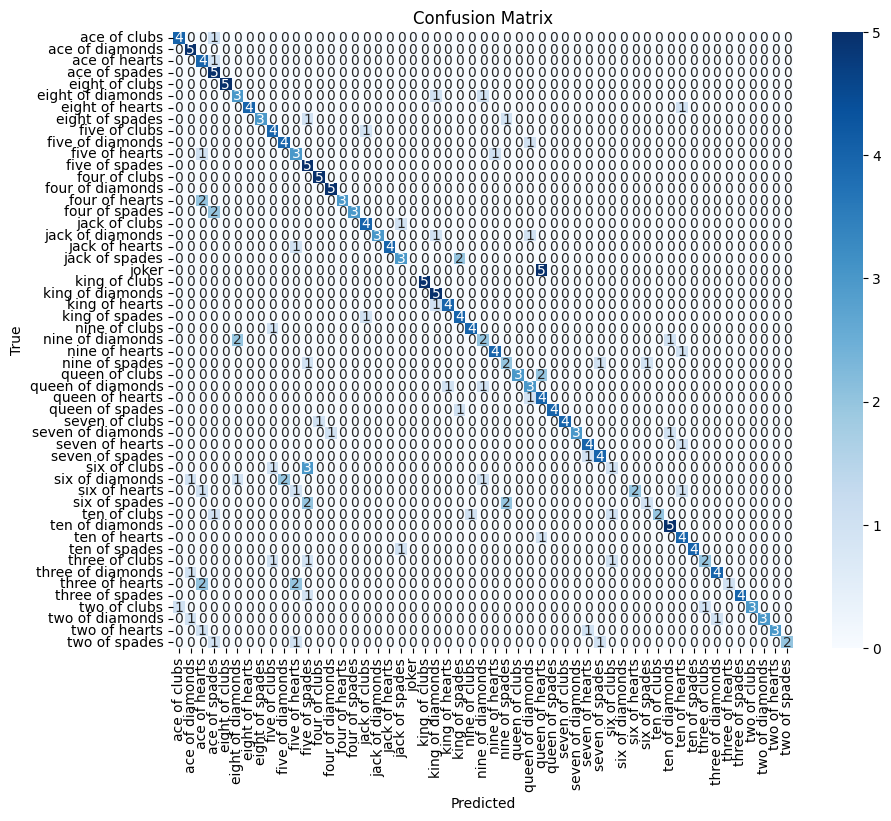

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
